# 1. Introduction

## Guidelines
Please complete the assignment inside this notebook. Make sure the code can be executed easily.

- Write production-ready code using OOP when relevant.
- For question 1, create simple unit tests for your code where applicable.
- For question 1, add comments and documentation strings for all methods. 
- For question 2 and 3, discuss your design choices.
- For question 2 and 3, discuss the complexity (Big O notation) of your solutions, both memory wise and performance wise.
- For question3, provide map visualization when relevant
- Try to stick to the most popular scientific Python libraries.
- Provide us with the instructions needed to run your code (e.g. requirements.txt, setup.py). Ideally, a simple virtualenv build and a `pip install` will do the trick.

## Input data
You should have received three csv files. Each csv-file represents the locations where a person was stationary for a certain amount of time. 
The csv-files contain the following fields:

- Latitude: The latitude of the detected GPS coordinates Longitude: The longitude of the detected GPS coordinates
- Timestamp: The start time of the stationary in the following format:
    - YYYY = year
    - MM = month of year
    - dd = day of month
    - HH=hourofday
    - mm = minute of hour
    - Z = timezone offset
- Duration: The length of time the person was stationary (in milliseconds)
    
All questions in this assignment are related to this data.

In [1]:
# import statements go here.
from operator import itemgetter
import unittest
import datetime
from datetime import timedelta

import pandas as pd
import numpy as np
from geopy.distance import geodesic
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering


# 2. Programming skills

## Question 1: Data parsing
- Create the code needed to read and parse the data.
- Print out some summary statistics of the data
    - e.g. Average number of places visited per day
    - e.g. Median distance traveled between two subsequent stationary locations
    - ...

In [2]:
# look at the data
! head person.*.csv
! wc -l person.*.csv

==> person.1.csv <==
latitude;longitude;start_time(YYYYMMddHHmmZ);duration(ms)
-49.326958;-72.89073;201312251147-0300;1186491
-49.32693;-72.89073;201312251213-0300;4393711
-49.31661;-72.8989;201312251358-0300;842939
-49.32716;-72.89072;201312251440-0300;211887
-49.32688;-72.89085;201312251631-0300;71166228
-49.326935;-72.89074;201312261221-0300;370057
-49.326935;-72.89071;201312261231-0300;7882206
-49.33384;-72.88286;201312261536-0300;1469429
-50.339264;-72.263306;201312261842-0300;331102

==> person.2.csv <==
latitude;longitude;start_time(YYYYMMddHHmmZ);duration(ms)
51.057022;3.714476;201312250036+0100;19593588
51.056984;3.7146811;201312250608+0100;30460679
51.038406;3.7296553;201312251451+0100;964169
50.88019;4.2511473;201312251514+0100;262475
50.861668;4.4750204;201312251524+0100;64461
50.87923;4.666252;201312251531+0100;68925
50.997192;4.8022957;201312251541+0100;11998026
50.997192;4.802296;201312251907+0100;18114776
50.997192;4.8022995;201312260015+0100;35447860

==> person.3.csv 

In [3]:
def compute_time_tz0(t, tz):
    """ compute UTC+0 time 

    Parameters:
    t : time of the day (relative to time zone)
    tz : string containing time and time zone

    Returns:
    sorted pandas dataframe
    """
    # extract hour
    h = int(tz[1:3])
    # extract minute
    m = int(tz[3:])
    # extract sign of time lag
    if tz[0] == '-':
        return t - timedelta(hours=h, minutes=m)
    elif tz[0] == '+':
        return t + timedelta(hours=h, minutes=m)


class PersonStationaryLocations():
    def __init__(self, person_id_list):
        self.person_id_list = person_id_list
        self.df = self.read_and_parse_several()
    
    @staticmethod
    def read_and_parse_single(fname):
        """ read and parse single file
        
        Parameters:
        fname : full csv file name
        
        Returns:
        sorted pandas dataframe
        """
        
        df = pd.read_csv(fname, sep=';')
        # problem when reading timezone with %z => separate timestamp and time zone
        df['time_zone'] = df['start_time(YYYYMMddHHmmZ)'].apply(lambda s : s[-5:])
        # local time
        df['start_time_tz'] = df['start_time(YYYYMMddHHmmZ)'].apply(lambda s : pd.to_datetime(s[:-5], format='%Y%m%d%H%M'))
        df['end_time_tz'] = df.apply(lambda row : row['start_time_tz'] + timedelta(seconds=int(row['duration(ms)']/1000)), axis=1)

        # time of the day
        df['start_hour'] = df['start_time_tz'].apply(lambda s : s.time())
        df['end_hour'] = df['end_time_tz'].apply(lambda s : s.time())

        # time UTC 0 (for sorting purpose only)
        df['start_time'] = df.apply(lambda row : compute_time_tz0(row['start_time_tz'], row['time_zone']), axis=1)
       
        # compute date
        df['date'] = df['start_time'].apply(lambda d : d.date())

        # sort df
        df = df.sort_values(by=['start_time']).drop('start_time', axis=1)
        return df

    
    def read_and_parse_several(self):
        """ read and parse several files
        
        Parameters:
        person_id_list : list of persons id
        
        Returns:
        pandas dataframe
        """
        df = None
        for id in self.person_id_list:
            fname = 'person.{}.csv'.format(id)
            dff = self.read_and_parse_single(fname)
            dff['person_id'] = id
            if df is None:
                df = dff
            else:
                df = pd.concat([df, dff], axis=0, ignore_index=True)

        # df already sorted

        return df
    

psl = PersonStationaryLocations([1, 2, 3])
psl.df.head()

latitude  longitude start_time(YYYYMMddHHmmZ)  duration(ms) time_zone  \
0 -49.326958  -72.89073         201312251147-0300       1186491     -0300   
1 -49.326930  -72.89073         201312251213-0300       4393711     -0300   
2 -49.316610  -72.89890         201312251358-0300        842939     -0300   
3 -49.327160  -72.89072         201312251440-0300        211887     -0300   
4 -49.326880  -72.89085         201312251631-0300      71166228     -0300   

        start_time_tz         end_time_tz start_hour  end_hour        date  \
0 2013-12-25 11:47:00 2013-12-25 12:06:46   11:47:00  12:06:46  2013-12-25   
1 2013-12-25 12:13:00 2013-12-25 13:26:13   12:13:00  13:26:13  2013-12-25   
2 2013-12-25 13:58:00 2013-12-25 14:12:02   13:58:00  14:12:02  2013-12-25   
3 2013-12-25 14:40:00 2013-12-25 14:43:31   14:40:00  14:43:31  2013-12-25   
4 2013-12-25 16:31:00 2013-12-26 12:17:06   16:31:00  12:17:06  2013-12-25   

   person_id  
0          1  
1          1  
2          1  
3          1  
4          1

In [4]:
# general dataset description
psl.df.describe()

latitude    longitude  duration(ms)    person_id
count  1669.000000  1669.000000  1.669000e+03  1669.000000
mean     41.391690    -2.728061  9.549358e+06     1.884961
std      29.653173    21.626538  1.671499e+07     0.727958
min     -54.866844   -73.033570  1.390000e+02     1.000000
25%      51.041492     4.350843  1.804400e+05     1.000000
50%      51.206913     4.394105  9.495870e+05     2.000000
75%      51.214268     4.411587  1.065583e+07     2.000000
max      51.586678     5.495329  1.631741e+08     3.000000

### Average number of places visited per day

In [5]:
def compute_average_number_of_places_visited_per_day(psl):
    """ Compute average number of places visited per day

    Parameters:
    psl : instance of PersonStationaryLocations

    Returns:
    pandas dataframe
    """
    
    df = psl.df
    
    # a single place is the combination of latitude and longitude
    df['lat-lon'] = df['latitude'].astype(str) + '//' + df['longitude'].astype(str)
    
    # get unique locations
    df = df[['person_id', 'date', 'lat-lon', 'latitude', 'longitude']].drop_duplicates()
    
    # count number of places per day
    df_places_per_day = df[['person_id', 'date', 'lat-lon']].drop_duplicates().groupby(['person_id', 'date']).count()
    # df_places_per_day
    
    return df_places_per_day.groupby(['person_id']).mean()


compute_average_number_of_places_visited_per_day(psl)

lat-lon
person_id          
1          6.873418
2          8.460674
3          6.296296

The average number of places visited per day is around 6 to 8, depending on the person.  

### Median distance traveled between two subsequent stationary locations

In [6]:
def compute_geodesic_distance(lat1, lon1, lat2, lon2):
    """ compute distance between 2 points

    Parameters:
    lat1 :  latitude point 1
    lon1 : longitude point 1
    lat2 :  latitude point 2
    lon2 : longitude point 2

    Returns:
    distance in km
    """
    
    try :
        return geodesic((lat1, lon1), (lat2, lon2)).kilometers
    except ValueError:
        return np.nan
    
    
def compute_geodesic_distance_df(row):
    """ compute distance between 2 points

    Parameters:
    row : dataframe row

    Returns:
    distance in km
    """
    
    lat1 = 'latitude'
    lon1 = 'longitude'
    lat2 = 'prev_lat'
    lon2 = 'prev_lon'
    
    return compute_geodesic_distance(row[lat1], row[lon1], row[lat2], row[lon2])

    
def compute_median_distance_traveled_between_two_subsequent_stationary_locations(psl):
    """ Compute median distance traveled between two subsequent stationary locations

    Parameters:
    psl : instance of PersonStationaryLocations

    Returns:
    pandas dataframe
    """
    
    df = psl.df # dataframe is sorted already
    df['lat-lon'] = df['latitude'].astype(str) + '//' + df['longitude'].astype(str)
        
    # get previous coordinates (df already sorted)
    df['prev_lat'] = df.groupby(['person_id'])['latitude'].shift(1)
    df['prev_lon'] = df.groupby(['person_id'])['longitude'].shift(1)

    df['distance_km_prev_place'] = df.apply(compute_geodesic_distance_df, axis=1)

    return df[['person_id', 'distance_km_prev_place']].groupby(['person_id']).median()



compute_median_distance_traveled_between_two_subsequent_stationary_locations(psl)

distance_km_prev_place
person_id                        
1                        0.465541
2                        0.456800
3                        3.629912

The average distance is not very relevant for person 1 (see below).  

### Is time_zone variable useful ?  
User 1 visited several time zones

In [7]:
psl.df[['person_id', 'time_zone']].drop_duplicates()

person_id time_zone
0             1     -0300
173           1     +0100
549           2     +0100
1312          3     +0100

### Duration of stay in fixed place

/home/drussier/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()


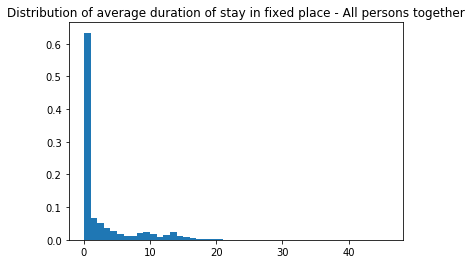

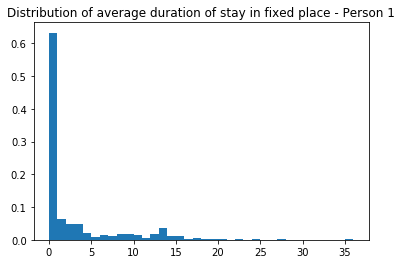

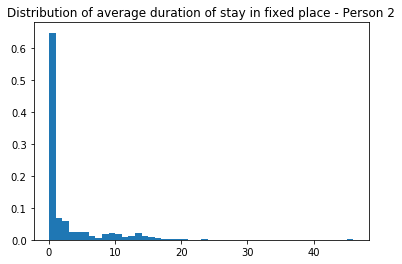

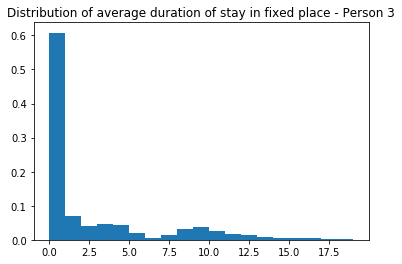

In [8]:
def plot_duration_in_place(psl):
    """ Plot average duration of stay

    Parameters:
    psl : instance of PersonStationaryLocations

    Returns:
    nothing
    """
    df = psl.df[['person_id', 'duration(ms)']]
    df['duration_hour'] = 1. * df['duration(ms)'] / (60 * 60 * 1000)

    data = df['duration_hour']
    weights = np.ones_like(data)/float(len(data))
    binwidth = 1

    # for all persons
    plt.title("Distribution of average duration of stay in fixed place - All persons together")
    plt.hist(data, weights=weights, bins=list(range(int(np.floor(min(data))), int(np.ceil(max(data))) + binwidth, binwidth)))
    plt.show()
    
    # per person 
    for id in df['person_id'].unique():
        df_id = df[df['person_id'] == id]

        data = df_id['duration_hour']
        weights = np.ones_like(data)/float(len(data))
        binwidth = 1

        plt.title("Distribution of average duration of stay in fixed place - Person {}".format(id))
        plt.hist(data, weights=weights, bins=list(range(int(np.floor(min(data))), int(np.ceil(max(data))) + binwidth, binwidth)))
        plt.show()
        

plot_duration_in_place(psl)

The vast majority of stays (> 60 %) have a duration shorter than 1 hour.  
### Rush hours

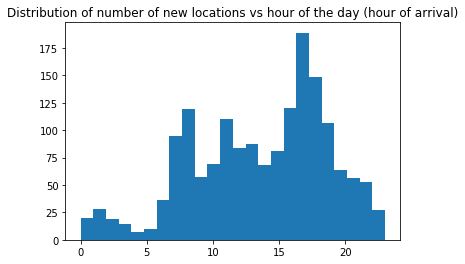

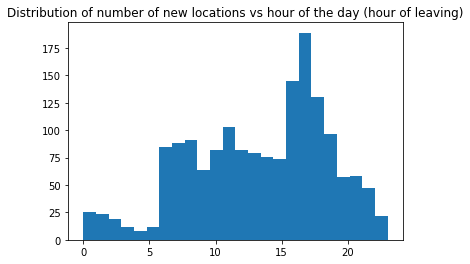

In [9]:
def plot_rush_hours(psl):
    """ Plot new locations per hour of the day

    Parameters:
    psl : instance of PersonStationaryLocations

    Returns:
    nothing
    """    
    df = psl.df

    df['start_h'] = df['start_hour'].apply(lambda t : t.hour)
    df['end_h'] = df['end_hour'].apply(lambda t : t.hour)

    plt.title("Distribution of number of new locations vs hour of the day (hour of arrival)")
    plt.hist(df['start_h'], bins=24)
    plt.show()

    plt.title("Distribution of number of new locations vs hour of the day (hour of leaving)")
    plt.hist(df['end_h'], bins=24)
    plt.show()
    
    
plot_rush_hours(psl)

Peak hours are between 6 am and 9 am in the morning, and between 4pm and 8 pm in the evening.  

### Some unit tests

In [10]:
class PersonStationaryLocationsTest(unittest.TestCase):
    
    def test_compute_time_tz0(self):
        self.assertEqual(compute_time_tz0(pd.Timestamp('2013-12-25 08:47:00'), '-0900'), pd.Timestamp('2013-12-24 23:47:00'))
    
    def test_df_content(self): 
        psl = PersonStationaryLocations([1])
        self.assertEqual(psl.df.iloc[0]['date'], datetime.date(2013, 12, 25))
        
    def test_df_length(self): 
        psl = PersonStationaryLocations([2])
        self.assertEqual(len(psl.df), 763)
        
    
if __name__ == '__main__':
    unittest.main(argv=['first-arg-is-ignored'], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.362s

OK


## Question 2: Data lookup
Create a method that generates a lookup table allowing us to effiently check whether or not a user has ever visited a location even if the new location is not exactly the same as the visited location (some noise is added to the longitude/latitude pairs).

This question is not 100% clear to me. 

A solution would be to:
1. store all different locations for every user   
    memory : O(n) (store all rows)  
    performance : O(1) (projection is immediate)   
2. for a given location, filter out all visited locations that don't respect a distance criteria  
    memory and performance : O(n) (compute and store distance with every location)  

In [11]:
def create_lookup_table(psl):
    """ Get all locations coordinates for each user

    Parameters:
    psl : instance of PersonStationaryLocations
    
    Returns:
    pandas dataframe
    """
    df = psl.df[['person_id', 'latitude', 'longitude']].drop_duplicates()
    return df


tbl = create_lookup_table(psl)
tbl.head()

person_id   latitude  longitude
0          1 -49.326958  -72.89073
1          1 -49.326930  -72.89073
2          1 -49.316610  -72.89890
3          1 -49.327160  -72.89072
4          1 -49.326880  -72.89085

In [12]:
def has_user_ever_visited_location(lookup_table, user_id, latitude, longitude, max_dist_km=0.1):
    """ Determine if a given user ever visited a location, with some tolerance

    Parameters:
    lookup_table : dataframe with person ids and locations visited
    user_id : ise rid
    latitude : current latitude
    longitude : current longitude
    max_dist_km : distance threshold (place considered as visited if distance < max_dist_km)

    Returns:
    boolean
    """
    df = lookup_table.loc[lookup_table['person_id'] == user_id]
    
    df['distance_km_to_new_location'] = df.apply(lambda row : geodesic((row['latitude'], row['longitude']), (latitude, longitude)).kilometers, axis=1)
    df = df.sort_values(by=['distance_km_to_new_location'], axis=0, ascending=True)
    df['visited'] = df['distance_km_to_new_location'].apply(lambda d : True if d < max_dist_km else False)
    df = df[['latitude', 'longitude', 'distance_km_to_new_location', 'visited']].reset_index(drop=True)
    return len(df.loc[df['visited'] == True]) > 0


user_id = 1
for lat, lon in [(-49.326958, -72.89073), (-49., -72.)]:
    print("Did user {} ever visit location ({}, {}) ? {}".format(user_id, lat, lon, has_user_ever_visited_location(tbl, user_id, lat, lon)))


/home/drussier/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


Did user 1 ever visit location (-49.326958, -72.89073) ? True
Did user 1 ever visit location (-49.0, -72.0) ? False


## Question 3: Home and work detection
The goal of this question, is to design an algorithm that allows us to distinguish the likely home locations of a user from his likely work locations.

Note that a person might have multiple home and work locations, or might not have a work location at all. Also note that the data might be noise, incorrect and/or incomplete.

Discuss your choice of algorithms, rules, methods, distance measures, etc.

**For this question, I will only perform an exploratory analysis and suggest some ideas. I won't propose a production-ready code.**

It's an unsupervised learning problem, consisting of multi-class classification (home, work, other). 2 solutions can be considered :  
1. label some data to have a supervised learning problem, but for this assignment we don't have relevant features (gender, age, whatever...) to train a classifier 
2. take an unsupervised learning approach. It's natural to think about clustering with space-time data.  

We can have access to external data that could help building prior about commuting times (for ex London traffic report https://www.tomtom.com/en_gb/traffic-index/london-traffic).  

### Plot data in (latitude, longitude) space  
Let's have a look at the data

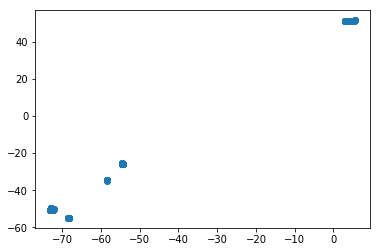

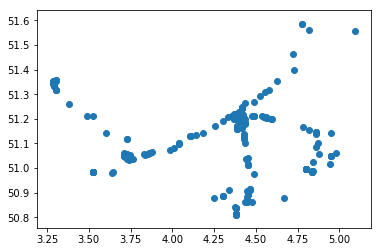

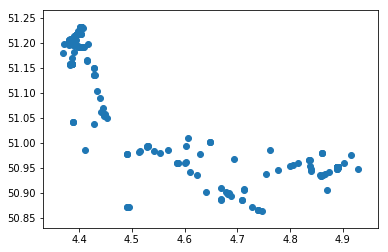

In [13]:
for id in psl.person_id_list:
    df = psl.df[psl.df['person_id'] == id]
    plt.scatter(x=df['longitude'], y=df['latitude'])
    plt.show()

NB : 1 degree of latitude or longitude is approximately equal to 110 km  
  
User 1 is travelling around the world (time zone changes)  
User 2 stays in a rectangular region of 100 km (latitude) by 200 km (longitude)  
User 3 stays in a rectangular region of  40 km (latitude) by  50 km (longitude)
  

**1st idea:** 
A user is most likely to be home at night (10 pm - 7 am) and at work during the day (9 am - 5 pm).


/home/drussier/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/drussier/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


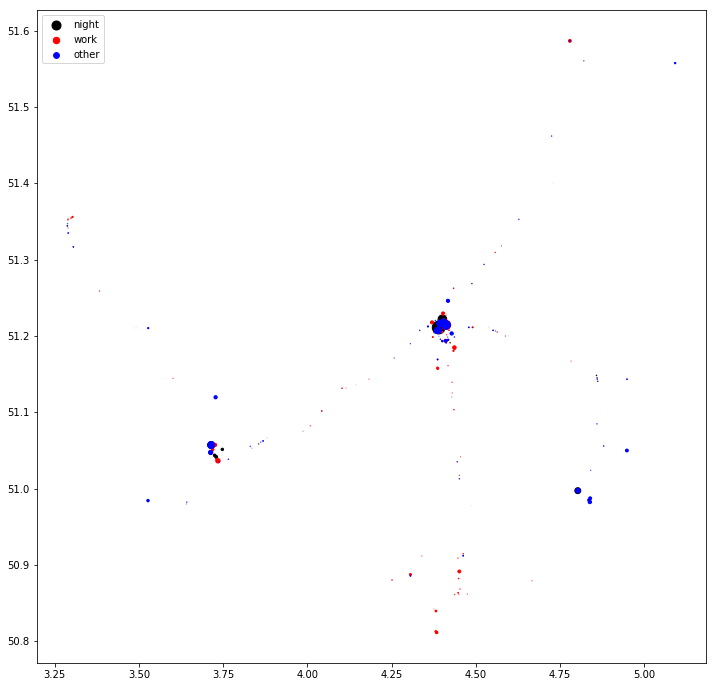

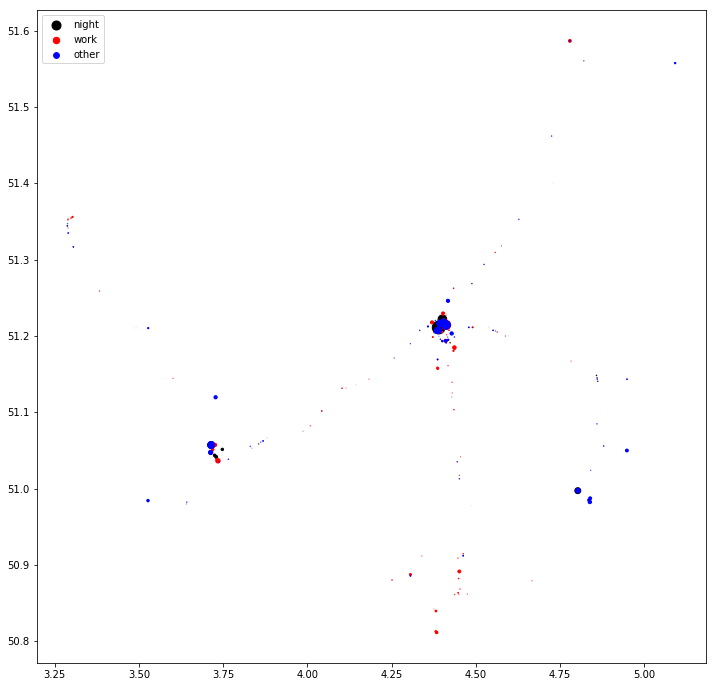

In [14]:
def plot_user_likely_location(psl, user_id):

    df = psl.df[psl.df['person_id'] == 2]
    df['night'] = df['start_hour'].apply(lambda s : True if (s > datetime.time(22, 0) or s < datetime.time(7, 0)) else False)
    df['work']  = df['start_hour'].apply(lambda s : True if (s > datetime.time(9, 0) and s < datetime.time(17, 0)) else False)

    df_night = df[df['night'] == True]
    df_work = df[df['work'] == True]
    df_else = df[(df['night'] == False) & (df['work'] == False)]
    plt.figure(figsize=(12, 12))
    
    s_factor = 0.000001
    
    plt.scatter(x=df_night['longitude'], y=df_night['latitude'], label='night', color='k', s=s_factor*df_night['duration(ms)'])
    plt.scatter(x=df_work['longitude'], y=df_work['latitude'], label='work', color='r', s=s_factor*df_work['duration(ms)'])
    plt.scatter(x=df_else['longitude'], y=df_else['latitude'], label='other', color='b', s=s_factor*df_else['duration(ms)'])
    plt.legend()
    plt.show()
    
    
plot_user_likely_location(psl, 2)
plot_user_likely_location(psl, 3)

It looks like user#2's home is located in the middle of the star scheme. His working place is probably on the lower left corner.  
1st idea : one can expect to see home and work locations appearing as separate groups in a scatter plot in the space (hour of the day, duration), because one stays around 9 hours a day at work and 10-12 hours at home.

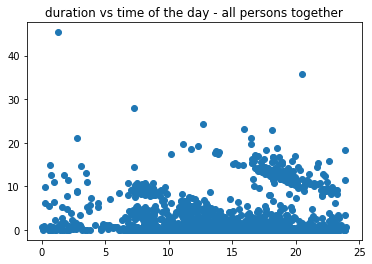

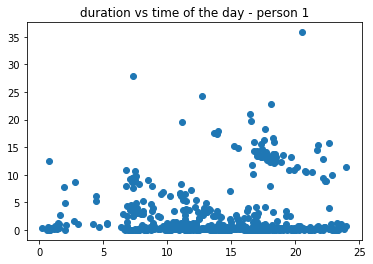

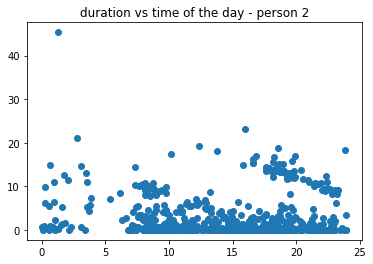

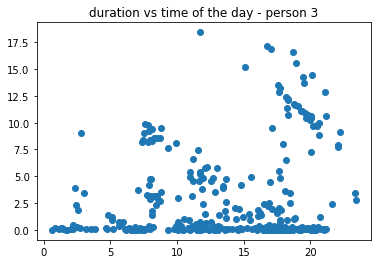

In [15]:
def plot_duration_vs_hour(psl):
    df = psl.df
    df['duration_hour'] = 1. * df['duration(ms)'] / (60 * 60 * 1000)
    df['start_hour_decimal'] = df['start_hour'].apply(lambda t : t.hour + t.minute / 60.)

    # all persons together
    plt.figure()
    plt.title('duration vs time of the day - all persons together')
    plt.scatter(df['start_hour_decimal'], df['duration_hour'])
    plt.show()    
    
    # per person
    for id in df['person_id'].unique():
        dff = df[df['person_id'] == id]

        plt.figure()
        plt.title('duration vs time of the day - person {}'.format(id))
        plt.scatter(dff['start_hour_decimal'], dff['duration_hour'])
        plt.show()
    
    
plot_duration_vs_hour(psl)

###  Clustering in (time of the day, duration) space  
We see indeed 2 groups of points corresponding to work and home. Let's try to isolate these groups from the rest of the data. For this we perform a spectral clustering  using polar coordinates.  
Why spectral clustering ? The idea is to separate "clusters [that] are nested circles on the 2D plan". 
See plots below and documentation :  
https://scikit-learn.org/stable/auto_examples/cluster/plot_cluster_comparison.html,  
https://scikit-learn.org/stable/modules/generated/sklearn.cluster.SpectralClustering.html#sklearn.cluster.SpectralClustering)


The parameters of the clustering algorithm are set manually (exploratory stage).
   

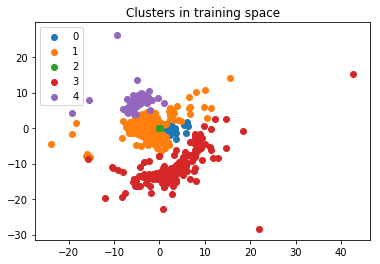

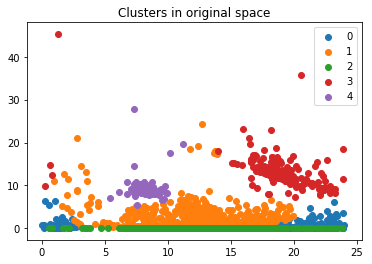

person 1


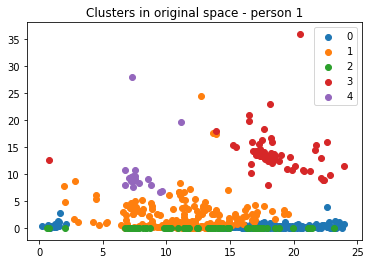

person 2


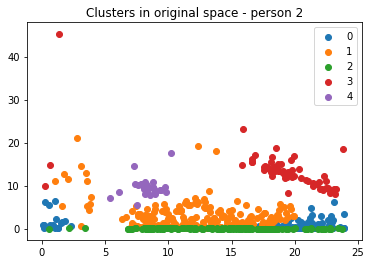

person 3


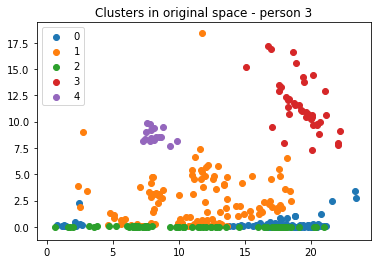

In [16]:
def plot_clusters_in_training_space(X_train):
    # plot clusters in training space
    plt.figure()
    plt.title('Clusters in training space')
    for label in sorted(X_train['label'].unique()):
        X_label = X_train[X_train['label'] == label]
        plt.scatter(X_label.values[:,0], X_label.values[:,1], label=label)

    plt.legend()
    plt.show()

    
def plot_clusters_in_original_space(df):
    # plot clusters in original space - all persons
    plt.figure()
    plt.title('Clusters in original space')
    for label in sorted(df['label'].unique()):
        df_label = df[df['label'] == label]
        plt.scatter(df_label['start_hour_decimal'], df_label['duration_hour'], label=label)

    plt.legend()
    plt.show()


    # plot clusters in original space - per person
    for id in sorted(df['person_id'].unique()):
        print('person {}'.format(id))
        dff = df[df['person_id'] == id]

        plt.figure()
        plt.title('Clusters in original space - person {}'.format(id))
        for label in sorted(df['label'].unique()):
            dff_label = dff[dff['label'] == label]
            plt.scatter(dff_label['start_hour_decimal'], dff_label['duration_hour'], label=label)

        plt.legend()
        plt.show()
        
        
    return df


def cluster_time_duration_data(psl):
    """ separate data in clusters in space (hour of the day, duration) 

    Parameters:
    psl : instance of PersonStationaryLocations

    Returns:
    dataframe with cluster labels
    """   

    df = psl.df.reset_index(drop=True)

    # filter out stays < 1h
    # df = df[df['duration(ms)'] > 1000 * 60 * 60]

    # convert duration in hours
    df['duration_hour'] = 1. * df['duration(ms)'] / (60 * 60 * 1000)
    
    # compute time of the day in decimal format (2h30 becomes 2.5)
    df['start_hour_decimal'] = df['start_hour'].apply(lambda t : t.hour + t.minute / 60.)

    # time of the day on the unit circle
    xs = np.cos(2. * np.pi * df['start_hour_decimal'] / 24.)
    ys = np.sin(2. * np.pi * df['start_hour_decimal'] / 24.)

    # training data in format (r*cosT, r*sinT), where r = duration and (cosT, sinT) = (xs, ys)
    X = pd.DataFrame(np.array([xs * df['duration_hour'].values, ys * df['duration_hour'].values]).T)
    assert X.shape[0] == len(df)

    # spectral clustering
    km = SpectralClustering(
        n_clusters=5, eigen_solver='arpack', affinity="nearest_neighbors", 
        random_state=0, n_init=10, n_neighbors=50)

    labels = km.fit_predict(X)
    assert len(df) == len(labels)
    df['label'] = pd.Series(labels, name='label')
    X['label'] = pd.Series(labels, name='label')
    
    plot_clusters_in_training_space(X)
    plot_clusters_in_original_space(df)
    
    return df


df_clusters = cluster_time_duration_data(psl)

Data points that probably correspond to work and home are well separated. We then identify the corresponding label by using a simple rule :  
- the 'home' label is the one with the highest percentage of points with start time between 7 and 10 am (label 3)  
- the 'work' label is the one with the highest percentage of points with start time between 5 and  9 pm (label 4)  


In [17]:
def get_label_with_max_frequency(df, feature):
    """ get label with highest percentage

    Parameters:
    df : dataframe after clustering
    feature : feature name to process

    Returns:
    label index
    """       
    # count per label
    tmp1 = df[['label']].reset_index().groupby(['label']).agg(['count'])
    tmp1.columns = ['total']
    # count per label and feature
    tmp2 = df.loc[df[feature] == 1, ['label', feature]].groupby(['label']).agg(['count'])
    tmp2.columns = ['total']
    # normalize count by label and feature
    tmp3 = tmp2 / tmp1
    # pick label with highest percentage
    return tmp3.idxmax()[0]


def get_home_and_work_labels(df):
    """ get labels corresponding to home and work 

    Parameters:
    df : dataframe after clustering

    Returns:
    dataframe, home label, work label
    """       
    # work cluster : start hour between 7 and 11
    # home cluster : start hour between 16 and 23
    df['start_h'] = df['start_hour'].apply(lambda t : t.hour)
    # df['go_home'] = df['start_hour'].apply(lambda s : True if (s > datetime.time(16, 0) and s < datetime.time(23, 0)) else False)
    # df['go_to_work']  = df['start_hour'].apply(lambda s : True if (s > datetime.time(7, 0) and s < datetime.time(11, 0)) else False)

    df['go_home']     = df['start_h'].apply(lambda h : True if (h >= 17 and h < 21) else False)
    df['go_to_work']  = df['start_h'].apply(lambda h : True if (h >=  7 and h < 10) else False)

    df[['label', 'go_home', 'go_to_work']].groupby('label').describe()
    home_label = get_label_with_max_frequency(df, 'go_home')
    work_label = get_label_with_max_frequency(df, 'go_to_work')
    
    return df, home_label, work_label

    
df_clusters, home_label, work_label = get_home_and_work_labels(df_clusters)
print("home label :", home_label)
print("work label :", work_label)

home label : 3
work label : 4


**Next step** is to look at the geographical situation of the clusters.

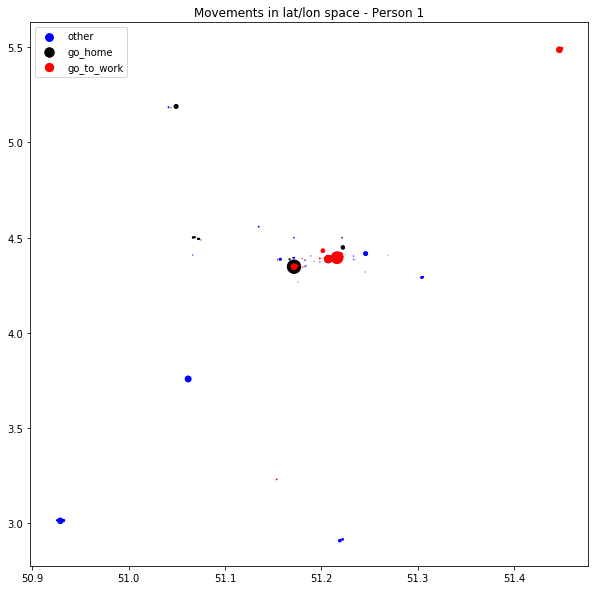

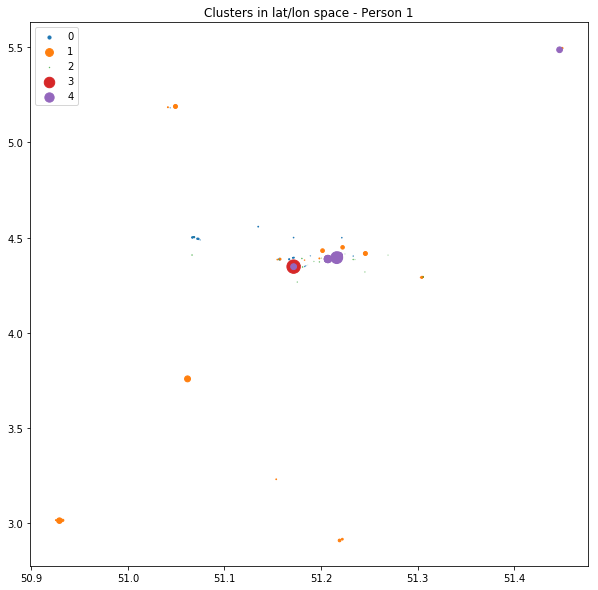

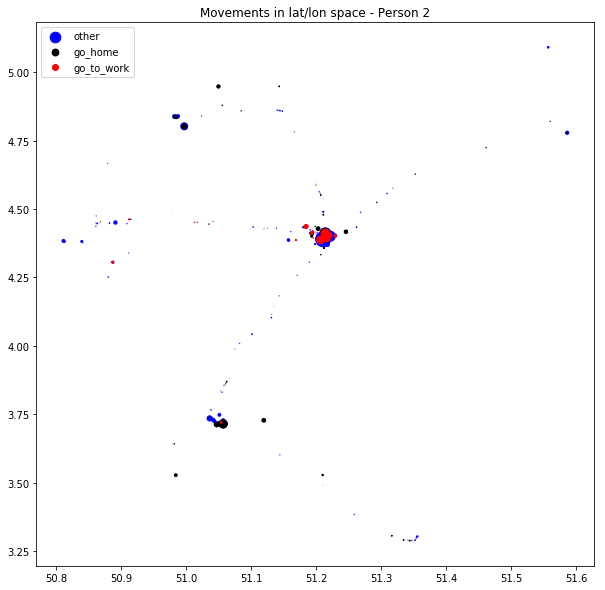

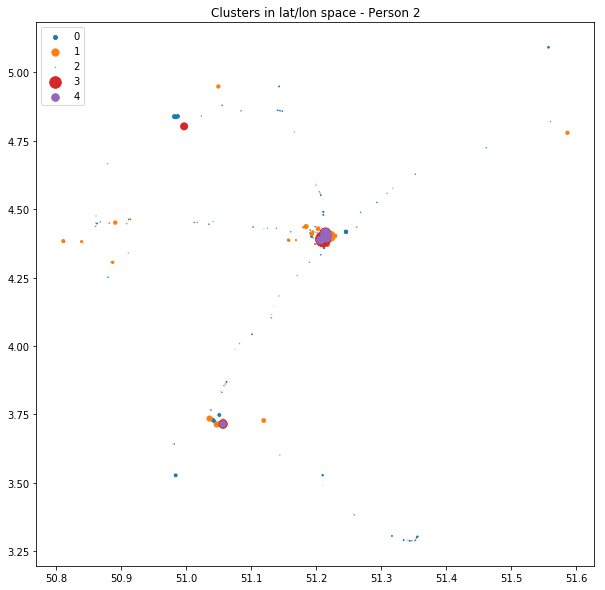

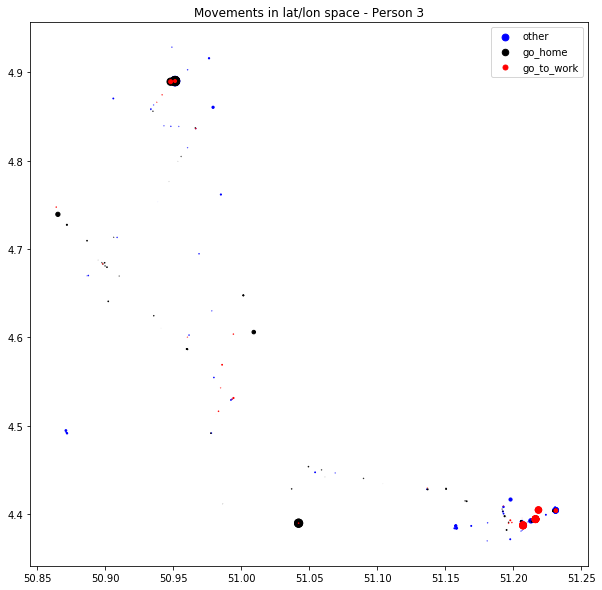

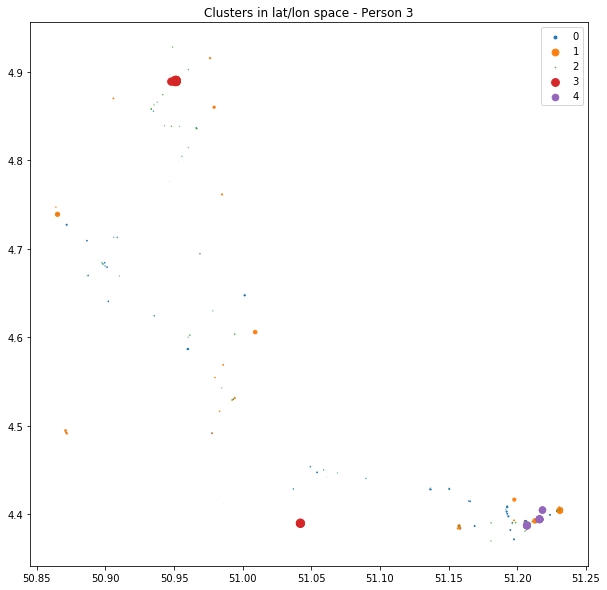

In [18]:
def plot_clusters_with_weights_in_lat_lon_space(df):

    df = df_clusters.copy()

    for id in df['person_id'].unique():
        df1 = df[df['person_id'] == id]

        # filter out stays < 1h
        # df1 = df1[df1['duration(ms)'] > 1000 * 60 * 60]

        if (id == 1):
            df1 = df1[df1['latitude'] > 40]

        plt.figure(figsize=(10, 10))
        # sc = plt.scatter(df1['latitude'], df1['longitude'], c=df1['start_hour_decimal'])

        s_factor = 5
        for feature, color in zip([None, 'go_home', 'go_to_work'], ['b', 'k', 'r']):    
            if feature is None:
                df_feature = df1[(df1['go_home'] == 0) & (df1['go_to_work'] == 0)]
                plt.scatter(
                    df_feature['latitude'], df_feature['longitude'], label='other', 
                    color=color, s=s_factor*df_feature['duration_hour'])
                # plt.scatter(df_feature['latitude'], df_feature['longitude'], c=df_feature['start_hour_decimal'])
            else:
                df_feature = df1[df1[feature] == 1]
                plt.scatter(
                    df_feature['latitude'], df_feature['longitude'], label=feature, 
                    color=color, s=s_factor*df_feature['duration_hour'])
                # plt.scatter(df_feature['latitude'], df_feature['longitude'], c=df_feature['start_hour_decimal'])

        plt.title('Movements in lat/lon space - Person {}'.format(id))
        # plt.colorbar(sc)
        plt.legend()
        plt.show()

        plt.figure(figsize=(10, 10))
        for label in sorted(df1['label'].unique()):
            try:
                df_label = df1[df1['label'] == label]
                plt.scatter(
                    df_label['latitude'], df_label['longitude'], label=label, 
                    s=s_factor*df_label['duration_hour'])
            except KeyError:
                pass

        plt.title('Clusters in lat/lon space - Person {}'.format(id))
        plt.legend()
        plt.show()
    
    
plot_clusters_with_weights_in_lat_lon_space(df_clusters)

We observe geographical clusters. 
### Guess possible work and home locations  
For each person and each label (work/home), we try to recursively group points together with a maximum distance criteria, starting with the point that has the highest duration.  
The duration can be seen as a likelihood, we rely more on locations with a big duration.    

Note : in the code below we average latitudes and longitude values. This is not relevant in general. But in the present case, we build local clusters with points that are very close (< 100 m). First order approximation : (lat, lon) coordinates are proportional to (x, y) coordinates at this scale.

In [19]:
def get_cluster_of_points(sorted_points_list, max_dist_km=0.1):
    """ group points with a distance criteria

    Parameters:
    sorted_points_list : list of points sorted by descending weight order
    max_dist_km : maximum distance threshold to define a group

    Returns:
    list of points in the same group as the first point of the input list
    list of remaining points
    """    
    if len(sorted_points_list) == 1:
        return sorted_points_list, []
    
    central_point = sorted_points_list[0]
    indexes = []
    for ii, pt in enumerate(sorted_points_list[1:]):
        d = geodesic((central_point[0], central_point[1]), (pt[0], pt[1])).kilometers
        if d < max_dist_km:
            indexes.append(ii)
            
    group = [central_point] + [sorted_points_list[1:][ii] for ii in range(len(sorted_points_list[1:])) if (ii in indexes)]
    remaining = [sorted_points_list[1:][ii] for ii in range(len(sorted_points_list[1:])) if not(ii in indexes)]
    return group, remaining


def cluster_points_by_duration_and_distance(sorted_points_list, max_dist_km=0.1):
    """ recursively group points with a distance criteria

    Parameters:
    sorted_points_list : list of points sorted by descending weight order
    max_dist_km : maximum distance threshold to define a group

    Returns:
    dictionary of groups of points
    """
    
    total_weight = sum([pt[2] for pt in sorted_points_list])
    groups = {}
    ii = 0
    remaining = sorted_points_list
    while remaining : # non empty list
        group, remaining = get_cluster_of_points(remaining, max_dist_km=max_dist_km)
        sum_weight = sum([pt[2] for pt in group])
        
        tmp = np.sum([pt[0] * pt[2] for pt in group])
        
        groups[ii] = {
            'points': group, 
            'weight': 1. * sum_weight / total_weight, 
            # local planar approximation
            'centroid': (np.sum([pt[0] * pt[2] / sum_weight for pt in group]), np.sum([pt[1] * pt[2] / sum_weight for pt in group]))
        }
        ii += 1
                         
    return groups



def compute_possible_home_work_locations(df):
    """ compute home and work locations

    Parameters:
    df : dataframe after clustering in (hour of the day, duration) space

    Returns:
    dataframe of locations for every user 
    """
    
    lst = []
    for id in sorted(df_clusters['person_id'].unique()):
        for label, label_name in zip([home_label, work_label], ['home', 'work']):
            df = df_clusters[(df_clusters['person_id'] == id) & (df_clusters['label'] == label)][['latitude', 'longitude', 'duration(ms)']]
            df_to_list = df.values.tolist()
            df_to_list.sort(key=itemgetter(2), reverse=True)
            groups = cluster_points_by_duration_and_distance(df_to_list)

            for gr in groups.values():
                lst.append([id, label, label_name, gr['centroid'][0], gr['centroid'][1], gr['weight']])


    return pd.DataFrame(lst, columns=['person_id', 'label', 'label_name', 'latitude', 'longitude', 'score'])
    
    
df_home_work = compute_possible_home_work_locations(df_clusters)
df_home_work

person_id  label label_name   latitude  longitude     score
0           1      3       home  51.171607   4.346980  0.877470
1           1      3       home -49.326880 -72.890850  0.022297
2           1      3       home -34.812263 -58.539413  0.020270
3           1      3       home -25.624393 -54.550688  0.046272
4           1      3       home -50.334320 -72.253230  0.017356
5           1      3       home -54.809326 -68.319530  0.016335
6           1      4       work  51.216317   4.394152  0.547691
7           1      4       work  51.207120   4.387023  0.264363
8           1      4       work  51.218621   4.404496  0.125433
9           1      4       work  51.171654   4.346833  0.031910
10          1      4       work  51.447030   5.486992  0.030603
11          2      3       home  51.210907   4.389543  0.049701
12          2      3       home  51.214262   4.411576  0.924598
13          2      3       home  51.057003   3.714637  0.014904
14          2      3       home  50.997192   4.802300  0.010797
15          2      4       work  51.214290   4.411608  0.141242
16          2      4       work  51.216306   4.394121  0.421500
17          2      4       work  51.207128   4.387065  0.310237
18          2      4       work  51.218465   4.404558  0.096517
19          2      4       work  51.056984   3.714681  0.030504
20          3      3       home  50.951206   4.889933  0.920849
21          3      3       home  51.042057   4.389605  0.056461
22          3      3       home  50.947964   4.889203  0.022690
23          3      4       work  51.207109   4.387133  0.263228
24          3      4       work  51.216315   4.394126  0.617340
25          3      4       work  51.218460   4.404515  0.119431

Quick check relevance of the results

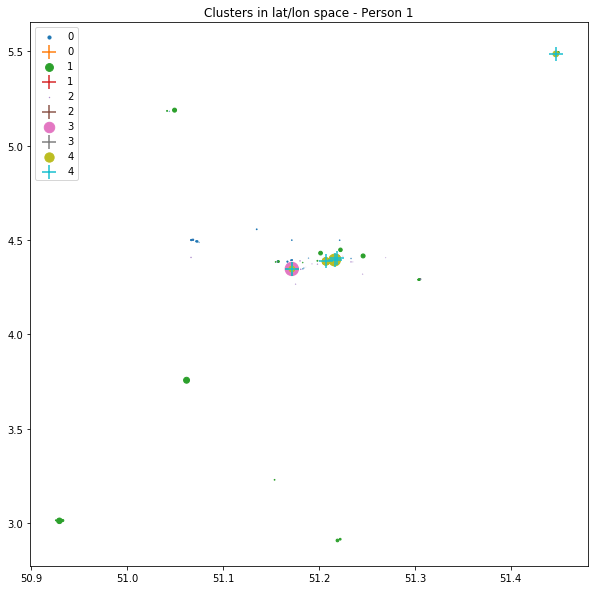

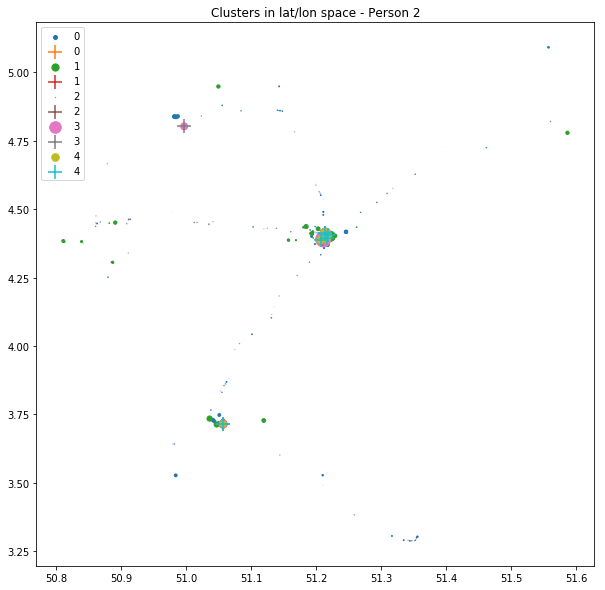

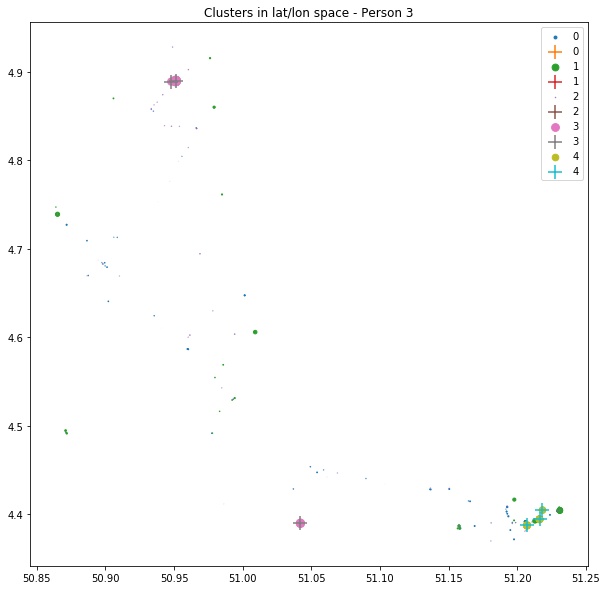

In [20]:
def plot_clusters_with_weights_and_centroids_in_lat_lon_space(df, df_home_work):

    s_factor = 5
    for id in df['person_id'].unique():
        df1 = df[df['person_id'] == id]
        df2 = df_home_work[df_home_work['person_id'] == id]
        

        if (id == 1):
            df1 = df1[df1['latitude'] > 40]
            df2 = df2[df2['latitude'] > 40]

        plt.figure(figsize=(10, 10))
        for label in sorted(df1['label'].unique()):
            try:
                df1_label = df1[df1['label'] == label]
                df2_label = df2[df2['label'] == label]
                plt.scatter(
                    df1_label['latitude'], df1_label['longitude'], label=label, 
                    s=s_factor*df1_label['duration_hour'])
                plt.scatter(
                    df2_label['latitude'], df2_label['longitude'], label=label, 
                    s=200, marker="+") # s_factor*100*df2_label['score']
            except KeyError:
                pass

        plt.title('Clusters in lat/lon space - Person {}'.format(id))
        plt.legend()
        plt.show()
    
    
plot_clusters_with_weights_and_centroids_in_lat_lon_space(df_clusters, df_home_work)

### Conclusion  

The home and work locations computed with this method look relevant.  
For this assignment, I don't have time to go deeper and propose a robust code implementation that could be run in production.  
Thanks for your understanding :p